# 1. Introduction
   The NCAA Division I Men’s Basketball Tournament, also known as March Madness, is one of the biggest sporting events of the year, and much of that has to do with the bracket challenge craze. Every year, roughly 70 million march madness brackets are submitted online, with the hopes of getting a perfect bracket. Considering how popular the bracket challenge is, you would think a perfect bracket had been achieved by now. However, this feat has never been accomplished in the history of the tournament, with the longest streak being 49 out of 63 games. The first reason for this is the sheer number of bracket possibilities that exist. Since there are 63 games played in the tournament, we can mathematically derive that there are 2⁶³, or about 9.2 quintillion, possible brackets every year. Although some games may be easier to predict than others, based on prior knowledge, college basketball has by far the most parity out of any American sports league. Due to the number of teams and distribution of talent, every single year we see many unpredictable upsets. This research project was conducted in the hopes of better predicting march madness in the future, in a few different ways. The first is by analyzing which regular season factors are the most telling of a team’s ability to perform in March. The second element was analyzing whether some of these regular season factors were more telling for certain conferences than others. For example, the Big East leads the country for most bids by a conference throughout history, but they are ranked 3rd in both Final Four appearances and National Champions. They trail in Final Four appearances to the ACC and the Big Ten, who are second and fourth in overall appearances; and they trail the Pac 10(Pac 12) and the ACC in National Champions, with the Pac 10 being 5th in overall appearances.

# 2. Literature Review
Ample research has been done on statistical methods to attempt to predict March Madness. The main difference with a lot of these methods and mine is that they typically focus on individual matchups and bracket building. This means that they are accounting for a teams opponent in each round to guess how far they will go, rather than my question that doesn’t employ the use of the bracket at all, but instead is trying to make predictions based on just a teams regular season. 

One paper that used multiple Bayesian techniques to find which was the most effective was Maddox et al. (2022). This paper introduces two new methods for estimating or predicting in-game win probabilities for NCAA basketball games. The first method is a Bayesian estimator with a dynamic prior that changes based on lead differential and time elapsed. The second method adds a time-weighted adjustment based on pre-game win probabilities computed from daily ratings. The comparison of these methods demonstrates that the proposed estimates outperform three standard methods in terms of estimation accuracy. For prediction, the adjusted dynamic Bayesian method performs the best based on Brier's score and misclassification rates. Further research is needed to determine appropriate methods for computing pre-game win probabilities, explore different window choices, optimize the weighting function, and extend these models to other sports.

Shi et al. (2013) employed machine learning and random forest methods, along with two other approaches, to predict outcomes of NCAA Division 1 basketball games between 2009 and 2013. Their findings indicated that the machine learning method outperformed the random forest method, but they emphasized that the factors considered in the models had a greater impact than the specific modeling techniques. They also concluded that having more training data did not necessarily lead to improved models. However, their methods focused solely on predicting individual game results, rather than focussing on teams expected outcomes.

On the other hand, Shen et al. (2015) developed a logistic linear model with probability self-consistency for March Madness bracketing. Probability self-consistency refers to the property where the probabilities of each team advancing to the next round, given that the team won all previous rounds, sum up to 1 within a set of competing teams. Shen et al. (2015) used the classical maximum likelihood estimation technique to estimate coefficients in their model. When comparing their approach to the restricted OLRE method proposed by West (2006); West (2008); Pomeroy (2015, 2016), and RPI (2015) using the 2014 March Madness tournament results, Shen et al.'s method outperformed the others, particularly in terms of double scoring.


In [1]:
import pandas as pd
import pymc as pm
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np

# 3. Data

   The dataset that I used was found on data.world(https://data.world/mkearney/ncaa-mens-cbb-teams). It was created by Michael Wayne Kearney, who said the data within the set was compiled from sport-reference.com. This dataset had statistics about every single Division I basketball team since 1957. The dataset included the teams conference, their wins, losses, SOS(strength of schedule), SRS(simple rating system), points for, points against, their AP ranking, and their NCAA tournament result. Since I was only worried about predicting how teams would do in the NCAA tournament, I only wanted to train my model on data from teams that had made the tournament. Because of that I filtered out teams that didn’t make the NCAA tournament, as well as data points that didn’t have all of the independent variables tracked. This meant my data was filtered to be teams that had made the tournament from 1995-2016, because SOS had not been a recognized statistic until 1995. Since this dataset included each teams conference and their NCAA tournament results, it allowed me to see if certain regular season factors were more telling of NCAA tournament success for some conferences over others, while also allowing me to make predictions for future teams heading to the NCAA tournament.

In [2]:
data = pd.read_csv("MarchMadnessFiltered.csv")

In [3]:
data

,school,conf,wl,srs,sos,pts_for,pts_vs,ap_final,ncaa_result
0,air-force,MWC,0.774,10.20,2.49,64.2,54.7,30,Lost First Round
1,air-force,MWC,0.759,9.12,0.08,59.9,50.9,30,Lost First Round
2,akron,MAC,0.788,8.11,0.18,71.8,62.8,30,Lost Second Round
3,akron,MAC,0.639,2.15,-1.02,70.1,65.7,30,Lost Second Round
4,akron,MAC,0.639,3.37,-2.01,66.8,60.3,30,Lost First Round
...,...,...,...,...,...,...,...,...,...
1339,xavier,A-10,0.813,13.90,4.09,72.4,62.6,22,Lost Second Round
1340,xavier,A-10,0.724,12.14,4.59,73.4,65.9,30,Lost First Round
1341,xavier,A-10,0.733,19.46,4.76,83.5,68.8,23,Lost First Round
1342,xavier,A-10,0.793,16.14,5.28,83.2,72.3,13,Lost Second Round


### 3.1
  In order to make this data usable, certain adjustments had to be made. First I wanted to make the AP Final Ranking variable into a binary variable, rather than showing teams exact rankings and leaving unranked teams empty. I felt that this would give a more holistic understanding of which teams had been good all season and which hadn’t. Next, I transformed my response variable, NCAA result, to a count variable. I did this by assigning each round a number, based on how many wins it would take to get to that round. This made my new response variable equal to NCAA tournament wins. The last thing I did was track each conference by number rather than name. This was done by assigning each conference a corresponding id, so that conference could be more easily iterable. 

In [4]:
data['ap_ranked'] = [None] * len(data)
index = 0
for i in data['ap_final']:
    if i == 30:
        data['ap_ranked'][index] = 0
    else:
        data['ap_ranked'][index] = 1
    index += 1
data['ap_ranked'] = data['ap_ranked'].astype(int)

/tmp/ipykernel_50/4145358928.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ap_ranked'][index] = 0
/tmp/ipykernel_50/4145358928.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['ap_ranked'][index] = 1


In [5]:
data['ncaa_round'] = [None] * len(data)
index = 0
for i in data['ncaa_result']:
    if i == 'Lost First Round':
        data.loc[index, 'ncaa_round'] = '0'
    elif i == 'Lost Second Round':
        data.loc[index, 'ncaa_round'] = '1'
    elif i == 'Lost Regional Semifinal':
        data.loc[index, 'ncaa_round'] = '2'
    elif i == 'Lost Regional Final':
        data.loc[index, 'ncaa_round'] = '3'
    elif i == 'Lost National Semifinal':
        data.loc[index, 'ncaa_round'] = '4'
    elif i == 'Lost National Final':
        data.loc[index, 'ncaa_round'] = '5'
    elif i == 'Won National Final':
        data.loc[index, 'ncaa_round'] = '6'
    index += 1

data['ncaa_round'] = data['ncaa_round'].astype(int)

In [6]:
confs = data['conf'].unique()

In [7]:
data['conf_id'] = [None] * len(data)
conf_id_index = 0
for i in confs:
    index = 0
    for j in data['conf']:
        if j == i:
            data['conf_id'][index] = conf_id_index
        index += 1
    conf_id_index += 1
        
data['conf_id'] = data['conf_id'].astype(int)

/tmp/ipykernel_50/758274966.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['conf_id'][index] = conf_id_index


In [8]:
data

,school,conf,wl,srs,sos,pts_for,pts_vs,ap_final,ncaa_result,ap_ranked,ncaa_round,conf_id
0,air-force,MWC,0.774,10.20,2.49,64.2,54.7,30,Lost First Round,0,0,0
1,air-force,MWC,0.759,9.12,0.08,59.9,50.9,30,Lost First Round,0,0,0
2,akron,MAC,0.788,8.11,0.18,71.8,62.8,30,Lost Second Round,0,1,1
3,akron,MAC,0.639,2.15,-1.02,70.1,65.7,30,Lost Second Round,0,1,1
4,akron,MAC,0.639,3.37,-2.01,66.8,60.3,30,Lost First Round,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1339,xavier,A-10,0.813,13.90,4.09,72.4,62.6,22,Lost Second Round,1,1,18
1340,xavier,A-10,0.724,12.14,4.59,73.4,65.9,30,Lost First Round,0,0,18
1341,xavier,A-10,0.733,19.46,4.76,83.5,68.8,23,Lost First Round,1,0,18
1342,xavier,A-10,0.793,16.14,5.28,83.2,72.3,13,Lost Second Round,1,1,18


# 4. Model
Since my response variable is a count variable that doesn’t deal with high values or overdispersion, I opted to use a poisson regression to model my data. With all my independent variables selected, the first step was to make a base poisson model. 

For this model I used these as my prior distrubtions:

$\beta_{0} \sim N(0, 2)$,
$\beta_{1} \sim N(0, 2)$,
$\beta_{2} \sim N(0, 2)$,
$\beta_{3} \sim N(0, 2)$,
$\beta_{4} \sim N(0, 2)$,
$\beta_{5} \sim N(0, 2)$

Deterministic:

$\mu = \beta_{0} + \beta_{1} win/loss + \beta_{2} sos + \beta_{3} ptsfor + \beta_{4} ptsvs + \beta_{5} apranked $

Likelihood:

$GamesWon \sim Poisson()$

In [9]:
# Load data
y = np.array(data['ncaa_round'])
X = np.array([data['wl'], data['sos'], data['srs'], data['pts_for'], data['pts_vs'], data['ap_ranked']]).T

In [10]:
with pm.Model() as unpooled_model:
    # Intercept for each county, distributed around group mean mu_a
    beta0 = pm.Normal('beta0', mu=0, sigma=2)
    # Slope for each county, distributed around group mean mu_b
    beta1 = pm.Normal('beta1', mu=0, sigma=2)
    beta2 = pm.Normal('beta2', mu=0, sigma=2)
    beta3 = pm.Normal('beta3', mu=0, sigma=2)
    beta4 = pm.Normal('beta4', mu=0, sigma=2)
    beta5 = pm.Normal('beta5', mu=0, sigma=2)
    
    # Expected value
    mu_ik = beta0 + beta1 * data['wl'] + beta2 * data['sos'] + beta3 * data['pts_for'] + beta4 * data['pts_vs'] + beta5 * data['ap_ranked']
       
    # Data likelihood
    y_like = pm.Poisson('y_like', mu=np.exp(mu_ik), observed=y)

In [11]:
with unpooled_model:
    unpooled_trace = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3, beta4, beta5]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 90 seconds.
The acceptance probability does not match the target. It is 0.88, but should be close to 0.8. Try to increase the number of tuning steps.


In [12]:
pm.summary(unpooled_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,-3.493,0.521,-4.536,-2.512,0.021,0.015,646.0,848.0,1.00
beta1,4.953,0.517,3.987,5.882,0.023,0.016,520.0,973.0,1.01
beta2,0.138,0.009,0.122,0.154,0.000,0.000,957.0,1196.0,1.00
beta3,0.009,0.010,-0.009,0.028,0.000,0.000,592.0,815.0,1.00
beta4,-0.023,0.011,-0.043,-0.001,0.000,0.000,553.0,744.0,1.00
beta5,-0.056,0.080,-0.215,0.086,0.003,0.002,976.0,982.0,1.00


In [13]:
print(unpooled_trace['posterior']['beta0'].values.mean(), unpooled_trace['posterior']['beta0'].values.std())
print(unpooled_trace['posterior']['beta1'].values.mean(), unpooled_trace['posterior']['beta1'].values.std())
print(unpooled_trace['posterior']['beta2'].values.mean(), unpooled_trace['posterior']['beta2'].values.std())
print(unpooled_trace['posterior']['beta3'].values.mean(), unpooled_trace['posterior']['beta3'].values.std())
print(unpooled_trace['posterior']['beta4'].values.mean(), unpooled_trace['posterior']['beta4'].values.std())
print(unpooled_trace['posterior']['beta5'].values.mean(), unpooled_trace['posterior']['beta5'].values.std())

-3.492709712754805 0.5204494975624026
4.952656545164848 0.5165803001026418
0.13806704845428408 0.008572522561805788
0.008793085080496914 0.009912115642693524
-0.02250279955415412 0.011218972704135603
-0.05583564875254389 0.08043444280137216


<function matplotlib.pyplot.show(close=None, block=None)>

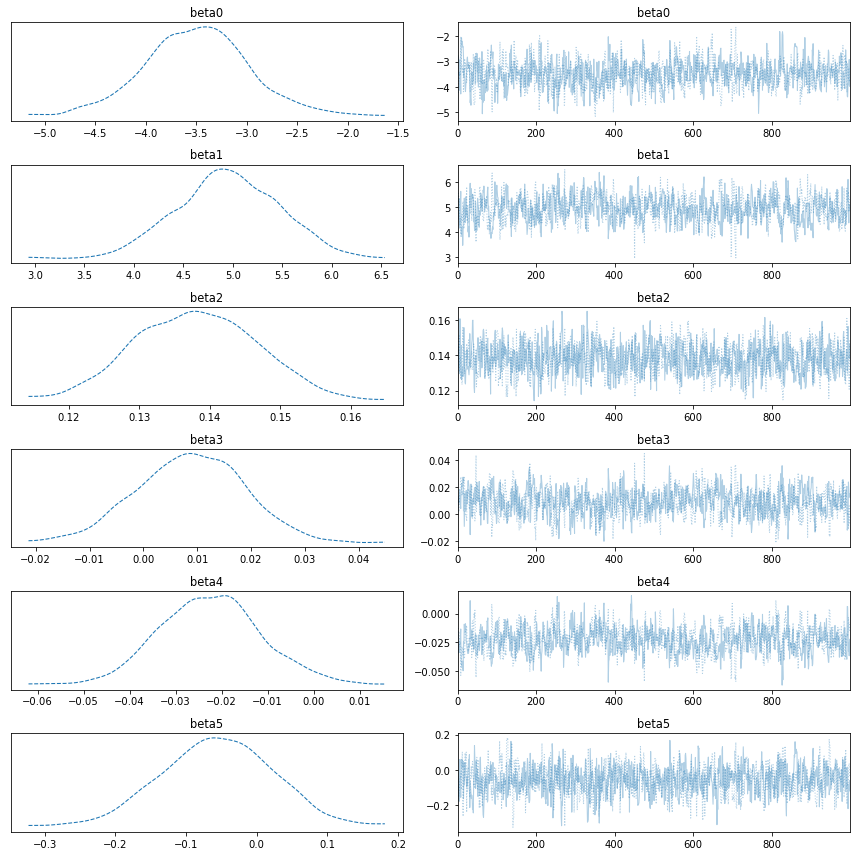

In [14]:
pm.plot_trace(unpooled_trace, combined=True);
plt.tight_layout()
plt.show

### 4.1
After running that, the next step was determining which betas should be hierarchical terms. I did this by making a standard generalized linear model with every term being grouped by conference. Although several divergences were present, each conference’s curve could be seen for each beta, in order to observe heterogeneity.

This model used these similar prior distrubtions:

$\beta_{0} \sim N(0, 2)$,
$\beta_{1} \sim N(0, 2)$,
$\beta_{2} \sim N(0, 2)$,
$\beta_{3} \sim N(0, 2)$,
$\beta_{4} \sim N(0, 2)$,
$\beta_{5} \sim N(0, 2)$

Deterministic:

$\mu = \beta_{0} + \beta_{1} win/loss + \beta_{2} sos + \beta_{3} ptsfor + \beta_{4} ptsvs + \beta_{5} apranked $

Likelihood:

$GamesWon \sim Poisson()$

In [15]:
with pm.Model() as pooled_model:
    # Intercept for each county, distributed around group mean mu_a
    beta0 = pm.Normal('beta0', mu=0, sigma=2, 
                       shape=len(data['conf_id'].unique()))
    # Slope for each county, distributed around group mean mu_b
    beta1 = pm.Normal('beta1', mu=0, sigma=2, 
                       shape=len(data['conf_id'].unique()))
    beta2 = pm.Normal('beta2', mu=0, sigma=2, 
                       shape=len(data['conf_id'].unique()))
    beta3 = pm.Normal('beta3', mu=0, sigma=2, 
                       shape=len(data['conf_id'].unique()))
    beta4 = pm.Normal('beta4', mu=0, sigma=2, 
                       shape=len(data['conf_id'].unique()))
    beta5 = pm.Normal('beta5', mu=0, sigma=2, 
                       shape=len(data['conf_id'].unique()))
    # std of likelihood
    sigma = pm.HalfCauchy('std', beta=1)
    
    # Expected value
    mu_ik = beta0[data['conf_id']] + beta1[data['conf_id']] * data['wl'] + beta2[data['conf_id']] * data['sos'] + beta3[data['conf_id']] * data['pts_for'] + beta4[data['conf_id']] * data['pts_vs'] + beta5[data['conf_id']] * data['ap_ranked']
    

    
    # Data likelihood
    y_like = pm.Poisson('y_like', mu=np.exp(mu_ik), observed=y)

In [16]:
with pooled_model:
    pooled_model = pm.sample(return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta0, beta1, beta2, beta3, beta4, beta5, std]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 745 seconds.
There were 178 divergences after tuning. Increase `target_accept` or reparameterize.
There were 68 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9015, but should be close to 0.8. Try to increase the number of tuning steps.


In [17]:
pm.summary(pooled_model)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0[0],0.618,1.741,-2.449,4.124,0.040,0.049,1891.0,836.0,1.00
beta0[1],-0.057,1.727,-2.963,3.381,0.034,0.045,2581.0,1435.0,1.00
beta0[2],-1.493,1.278,-3.757,1.087,0.030,0.024,1783.0,1273.0,1.00
beta0[3],0.304,1.916,-3.320,3.911,0.036,0.049,2811.0,1267.0,1.00
beta0[4],-2.122,1.670,-5.384,0.749,0.030,0.028,3180.0,1393.0,1.00
...,...,...,...,...,...,...,...,...,...
beta5[34],-0.006,2.092,-3.656,4.302,0.045,0.063,2173.0,915.0,1.01
beta5[35],-0.010,2.035,-4.065,3.675,0.042,0.060,2402.0,1012.0,1.00
beta5[36],0.007,1.982,-3.801,3.559,0.041,0.051,2369.0,1330.0,1.00
beta5[37],0.021,1.932,-3.488,3.772,0.038,0.058,2568.0,928.0,1.00


### 4.2
By looking at the plots for my beta coefficients, I found that heterogeneity was present in beta0; beta1, the win/loss beta; and beta5, the ap ranked beta, meaning that those 3 betas would be hierarchical in my final model.

<function matplotlib.pyplot.show(close=None, block=None)>

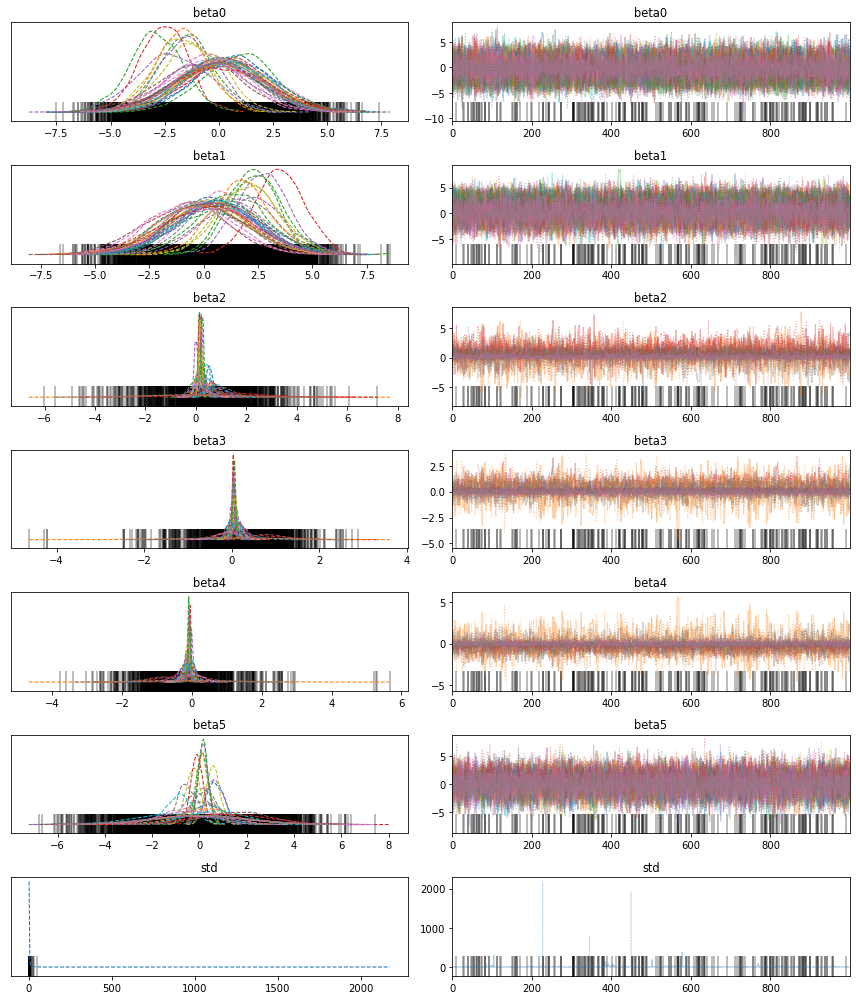

In [18]:
pm.plot_trace(pooled_model, combined=True);
plt.tight_layout()
plt.show

### 4.3 
Due to the lack of heterogeniety in some of the hierarchical x variables, and in order to insure the lack of divergences, the three hierarchical terms were converted to be uncentered through the addition of an offset variable. This variable effectively shifts the predicted values up or down by a constant amount, regardless of the values of the other predictor variables. This constant shift breaks the symmetry of the predicted values around zero, and the resulting model is said to be "uncentered".

<AxesSubplot:xlabel='conf_id'>

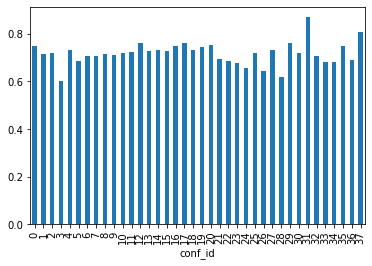

In [19]:
data.groupby('conf_id')['wl'].mean().plot(kind='bar')

### 4.4
In order to construct my model with those 3 hierarchical terms, I had to construct hyperpriors and priors for the remaining terms. I used the posterior distributions of my base models to construct my new priors and hyperpriors. After, running the model a few times, and adjusting the values slightly, I ended with the following priors:
- Priors:
  - $\mu_{\beta_0} \sim N(-3,2)$
  - $\sigma_{\beta_0} \sim HalfCauchy(1)$
  - $\mu_{\beta_1} \sim N(5,2)$
  - $\sigma_{\beta_1} \sim HalfCauchy(1)$
  - $\mu_{\beta_4} \sim N(0,2)$
  - $\sigma_{\beta_4} \sim HalfCauchy(1)$
- Group Priors:
  - $\beta_{0} \sim N(\mu_{\beta_0}, \sigma_{\beta_0})$
  - $\beta_{1} \sim N(\mu_{\beta_1}, \sigma_{\beta_1})$
  - $\beta_{2} \sim N(0, 0.001)$
  - $\beta_{3} \sim N(0, 0.01)$
  - $\beta_{4} \sim N(0, 0.01)$
  - $\beta_{5} \sim N(\mu_{\beta_5}, \sigma_{\beta_5})$
- Deterministics:
  - $\mu = \beta_{0} + \beta_{1} win/loss + \beta_{2} sos + \beta_{3} ptsfor + \beta_{4} ptsvs + \beta_{5} apranked $
- Likelihood:
  - $GamesWon \sim Poisson()$

In [20]:
with pm.Model() as hierarchical_model:
    # Hyperpriors
    mu_beta0 = pm.Normal('mu_beta0', mu=-3, sigma=2)
    sigma_beta0 = pm.HalfCauchy('sigma_beta0', beta=1)
    mu_beta1 = pm.Normal('mu_beta1', mu=5, sigma=2)
    sigma_beta1 = pm.HalfCauchy('sigma_beta1', beta=1)
    mu_beta5 = pm.Normal('mu_beta5', mu=0, sigma=2)
    sigma_beta5 = pm.HalfCauchy('sigma_beta5', beta=1)
    
    # Intercept for each county, distributed around group mean mu_a
    beta0_offset = pm.Normal('beta0_offset', mu=0, sigma=1, shape=(len(data['conf_id'].unique())))
    beta0 = pm.Deterministic('beta0', mu_beta0 + beta0_offset * sigma_beta0)
    
    # Slope for each county, distributed around group mean mu_b
    beta1_offset = pm.Normal('beta1_offset', mu=0, sigma=1, shape=(len(data['conf_id'].unique())))
    beta1 = pm.Deterministic('beta1', mu_beta1 + beta1_offset * sigma_beta1)
    beta2 = pm.Normal('beta2', mu=0, sigma=0.001)
    beta3 = pm.Normal('beta3', mu=0, sigma=0.01)
    beta4 = pm.Normal('beta4', mu=0, sigma=0.01)
    beta5_offset = pm.Normal('beta5_offset', mu=0, sigma=1, shape=(len(data['conf_id'].unique())))
    beta5 = pm.Deterministic('beta5', mu_beta5 + beta5_offset * sigma_beta5)
    
    # Expected value
    mu_ik = beta0[data['conf_id']] + beta1[data['conf_id']] * data['wl'] + beta2 * data['sos'] + beta3 * data['pts_for'] + beta4 * data['pts_vs'] + beta5[data['conf_id']] * data['ap_ranked']
    

    
    # Data likelihood
    y_like = pm.Poisson('y_like', mu=np.exp(mu_ik), observed=y)

In [ ]:
with hierarchical_model:
    hier_trace = pm.sample(return_inferencedata=True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_beta0, sigma_beta0, mu_beta1, sigma_beta1, mu_beta5, sigma_beta5, beta0_offset, beta1_offset, beta2, beta3, beta4, beta5_offset]


In [ ]:
summary_table = pm.summary(hier_trace)
summary_table

# 5. Results
The model had no error messages as there were no divergences in the sampling process. The model clearly displayed convergence, meaning that the samples from the posterior distribution are stable and do not change significantly as additional samples are obtained. This means the parameter space was thourougly explored and the data reliably estimates the posterior distributions. This can be seen by the Gelman Rubin statistic(r-hat) in the summary table above. All r-hat values are at 1.0 or close to 1.0, meanig the chains have converged to the same distribution

In [ ]:
summary_table['r_hat'].max()

In [ ]:
pm.plot_trace(hier_trace, combined=True);
plt.tight_layout()
plt.show

### 5.1
By looking at the plots of the beta coefficients above, we can clearly see the different distributions for different conferences, for the betas that were made hierarchical. This is especially present in beta0 and beta1, with some discrepency in beta5 as well. In order to see which conferences are more or less weighted for each beta, I looked for outliers of conference means for each of the three betas.

In [ ]:
beta5_coefs = summary_table[199:]
beta5_coefs['mean'].quantile([0.25,0.5,0.75])

In [ ]:
beta5_pos = beta5_coefs['mean'] > 0.2
beta5_neg = beta5_coefs['mean'] < 0.17

In [ ]:
beta5_pos_conf = ['MWC', 'CUSA', 'Pac-10', 'WAC']
beta5_neg_conf = ['Pac-12', 'ACC', 'WCC', 'A10']

### 5.2
Although the differences in the high means and low means were very small for beta5, there were still some conferences that had slightly higher and lower means than average. MWC, CUSA, Pac-10, and WAC had slightly higher than average beta5 means, while Pac-12, ACC, WCC, and A10 had slightly lower than average beta5 means. Since beta5 was the binary AP ranked variable's coeffieint, this equates to the fact that teams from the MWC, CUSA, Pac-10, and WAC that are ranked have their win total increased more than teams from other conferences that are ranked. Similarly teams from Pac-12, ACC, WCC, and A10 that are ranked have their win total increased by less than teams from other conferences. Since the discrepency was so small between all of the conferences, I don't believe that these differences tell us much about the conferences, as they were so minor.

In [ ]:
beta1_coefs = summary_table[161:199]
beta1_coefs['mean'].quantile([0.25,0.5,0.75])

In [ ]:
beta1_pos = beta1_coefs['mean'] > 4.9
beta1_neg = beta1_coefs['mean'] < 4.4

In [ ]:
beta1_pos_conf = ['SEC','Pac-10','ACC','Big East','Big Ten']
beta1_neg_conf = ['NEC','AEC']

### 5.3
The beta1 coefficient showed a lot of heterogeniety in its distributions, by conference. Since beta1 is the coefficient for win loss ratio, a difference in its weighting, by conference made sense to me, as teams in stronger conferences would probably have a more meaninful win loss ratio. The conferences that were positive outliers, meaning an increased win loss ratio for them would lead to more of an increase in games won, compared to other conferenecs, were the SEC, Pac-10, ACC, Big East, and Big Ten. Contrastingly, the conferences that were negative outliers, meaning an increased win loss ration for them would lead to less of an increase in games won, compared to other conferences were the NEC and AEC. Considering the conferences that were positive outliers were stronger conferences and the negative outliers were weaker conferences, these results seemed to make sense.

In [ ]:
beta0_coefs = summary_table[123:161]
beta0_coefs['mean'].quantile([0.25,0.5,0.75])

In [ ]:
beta0_pos = beta0_coefs['mean'] > -3.3
beta0_neg = beta0_coefs['mean'] < -4

In [ ]:
beta0_pos_conf = ['SEC','Pac-12','Pac-10','Big 12','ACC','Big East','AAC']
beta0_neg_conf = ['SWAC','OVC','AEC','NEC','A-Sun','Mid-Cont']

### 5.4
Finally, the beta0 coefficient, showed the most heterogeniety across conferencesm out of the three hierarchical terms. Beta0 is the intercept, so it represents the bass number of wins per conference, without all other variables. The presence of so much heterogeniety also makes sense here because some conferences are historically better than others, so naturally their bass wins would be higher. The confereneces that are positive outliers, meaning they have a higher number of base wins, are the SEC, Pac-12, Pac-10, Big 12, ACC, Big East, and AAC, while the conferences that are negative outliers, meaning they have a lower number of base wins, are the SWAC, OVC, AEC, NEC, A-Sun, and Mid-Cont. Similarly to beta1, this seems to make sense as the conferences with higher base wins are stronger conferences, while the conferences with lower base wins are weaker conferences.

In [ ]:
beta0_trace = hier_trace['posterior']['beta0'].values
beta1_trace = hier_trace['posterior']['beta1'].values
beta2_trace = hier_trace['posterior']['beta2'].values
beta3_trace = hier_trace['posterior']['beta3'].values
beta4_trace = hier_trace['posterior']['beta4'].values
beta5_trace = hier_trace['posterior']['beta5'].values

In [ ]:
new_data = pd.read_csv("2016 MM Data.csv")

In [ ]:
new_data.rename(columns = {'Unnamed: 1': 'Result'}, inplace = True)

In [ ]:
new_data

In [ ]:
new_data['ap_ranked'] = [None] * len(new_data)
index = 0
for i in new_data['ap_final']:
    if i == 30:
        new_data['ap_ranked'][index] = 0
    else:
        new_data['ap_ranked'][index] = 1
    index += 1
new_data['ap_ranked'] = new_data['ap_ranked'].astype(int)

In [ ]:
newconfs = new_data['conf'].unique()
new_data['conf_id'] = [None] * len(new_data)
conf_id_index = 0
for i in newconfs:
    index = 0
    for j in new_data['conf']:
        if j == i:
            new_data['conf_id'][index] = conf_id_index
        index += 1
    conf_id_index += 1
        
new_data['conf_id'] = new_data['conf_id'].astype(int)

In [ ]:
new_data['ncaa_round'] = " " * len(new_data)

In [ ]:
new_data

### 5.5
In order to use my model to make predictions for new data points, I conducted posterior predictions, by extracting the posterior beta distributions. My new data that I wanted to make predictions for was the 2016-2017 data, so that I could compare it to the actual results. After importing my new dataset, I took the same steps that I did at the begging of my data collection, to make the data applicable to the model. After extracting the posterior beta distrubitons, I used those distributions as my new beta priors when running my model on the new data. For each new data points, I made a posterior distribution for predicted games won, that I used in two different ways. First I took the mean of each teams posterior distibution to get a singular value to use as the prediction. Second, I split the distrubtion into 7 different bins, to find the probability of eah possible number of wins for each team. While this is a legitamite way of calculating probability of making each round, a more accurate approach would've been to make a second model that was a multinomial logisitc regression for orgdinal data, rather than a poisson regression.

In [ ]:
n_data_points = len(new_data)
y_prob = np.zeros((n_data_points, 1000, 2))
y_pred = np.zeros(n_data_points)

In [ ]:
for i in range(n_data_points):
    mu_ik_pred = beta0_trace.T[new_data['conf_id']] + beta1_trace.T[new_data['conf_id']] * new_data['wl'][i] + beta2_trace.T * new_data['sos'][i] + beta3_trace.T * new_data['pts_for'][i] + beta4_trace.T * new_data['pts_vs'][i] + beta5_trace.T[new_data['conf_id']] * new_data['ap_ranked'][i]
    y_prob[i] = np.exp(mu_ik_pred[i])
    y_pred[i] = np.exp(mu_ik_pred[i].mean())

In [ ]:
probs = np.zeros((64, 7))

In [ ]:
for i in range(n_data_points):
    prob0 = (y_prob[i][y_prob[i] < 0.75].size)
    prob1 = (y_prob[i][y_prob[i] < 1.75].size - prob0)
    prob2 = (y_prob[i][y_prob[i] < 2.75].size - prob1 - prob0)
    prob3 = (y_prob[i][y_prob[i] < 3.75].size - prob2 - prob1 - prob0)
    prob4 = (y_prob[i][y_prob[i] < 4.75].size - prob3 - prob2 - prob1 - prob0)
    prob5 = (y_prob[i][y_prob[i] < 5.75].size - prob4 - prob3 - prob2 - prob1 - prob0)
    prob6 = (y_prob[i][y_prob[i] >= 5.75].size)
    probs[i][0] = prob0/2000
    probs[i][1] = prob1/2000
    probs[i][2] = prob2/2000
    probs[i][3] = prob3/2000
    probs[i][4] = prob4/2000
    probs[i][5] = prob5/2000
    probs[i][6] = prob6/2000

In [ ]:
probTable = pd.DataFrame(probs)
probTable['School'] = [None] * len(new_data)
probTable['School'] = new_data['school']
probTable

In [ ]:
new_data['ncaa_round'] = y_pred

In [ ]:
new_data['diff'] = abs(new_data['ncaa_round'] - new_data['Result'])

In [ ]:
new_data

### 5.6
Each teams predicted number of wins was compared to their actual number of wins in the 2017 NCAA tournament, to see the accuracy of the results on this seasons data. The median difference was 0.58 games while the mean difference was 0.85 games, meaning that the model performed pretty well and that positive outliers slightly skewed the mean difference. The histogram of difference in predictions, shows that 48 out of 64 teams were predicted within 1 game, with 28 of those being within half a game. Since my model outputs a float rather than integer, if we round down values that are 0.5 and below and round up values that are 0.5 and above, 43.75% of the teams were predicted correctly and 35.3% of teams were predicted wtihin 1 game. This means only 18.75% of teams were mispredicted by 2 or more games, with only 7.8% of those being mispredicted by 3 or more games.

In [ ]:
new_data['diff'].median()

In [ ]:
new_data['diff'].mean()

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(new_data['diff'], bins=10, range=[0,5])
ax.set_title("Visualizing the Models Accuracy for the 2016-2017 Season")
  
# adding labels
ax.set_xlabel('Absolute Value of Difference Between Prediction and Actual')
ax.set_ylabel('Count')

rects = ax.patches
labels = [28, 20, 4, 5, 2, 2, 1, 1, 1]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')
  
# Show plot
plt.show()

# 6. Conculsion
This research was done with the hopes of answering two questions: Are certain regular season factors more telling for teams in certain conferences than others? Can we use regular season data to accurately predict NCAA tournament results for future data? 

After analyzing the model’s results, we can conclude that win-loss ratio is certainly more telling for certain conferences than others. Win-loss ratio is more impactful to a team’s total tournament wins if they are in the SEC, Pac-10, ACC, Big East, and Big Ten, and less impactful to their total tournament wins if they are in the NEC and AEC. All five of the positively outlying conferences are ranked top 6 in most tournament appearances, most final four appearances, and most NCAA championships. Since 1985, the NEC is 0-20 and the AEC is 1-20 in the NCAA tournament. Yet, many of these teams have good regular season records, further agreeing with our models conclusion that increased win loss ratio in these conferences does not equate to nearly as much increased march madness wins as other conferences.

The intercept value also showed extreme variation between conferences. Both of these things are very telling, and looking at which conferences show higher or lower values of those two coefficients is also very telling. A higher intercept for a certain conference means that that conference has a higher expected win total, without accounting for the other independent variables. The intercept was significantly higher for the SEC, Pac-10, Pac-12, ACC, Big East, Big 12, and AAC, while significantly lower for SWAC, OVC, NEC, AEC, A-Sun, and Mid-Cont. The 6 conferences(Pac-10 became Pac-12) that have positively outlying coefficients are ranked all in the top 7 for march madness appearances, final four appearances, and national championships. One interesting thing that stood out was how the Big Ten was not a positive outlier for the intercept, but was a positive outlier for the win-loss coefficient. Considering the Big 10 is 4th in tournament appearances and 2nd in final four appearances, this tells us that Big 10 teams with good records consistently perform well at the NCAA tournament, but that they also have many teams that qualify with worse records who consistently exit the tournament early. This is what causes them to not have a positively outlying base expected wins value. The 4 conferences that have negatively outlying coefficients have a combined 21-158 record. With an 11% win rate in the tournament, a lower base expected wins for these conferences is fitting.

To test if my model could be used on future regular season data to predict March Madness tournament results, the model was run on the 2016-2017 regular season data and compared to the results of the 2017 NCAA tournament. The model performed at a decently high level of accuracy predicted all 64 teams at an average error of 0.855 games, and a median of 0.582 games. Nearly 44% of teams were predicted correctly, with an additional 35% of teams being predicted within one game. Running the model on more than one years worth of data would further allow us to evaluate the accuracy of the model, however for the sample size that was provided, the results were pretty good.


# Citations
Shen, G., S. Hua, X. Zhang, Y. Mu and R. Magel, 2015. Predicting results of March madness using the probability selfconsistent method. International Journal of Sports Science, 5(4): 139-144. 

Shi, Z., S. Moorthy and A. Zimmermann, 2013. Predicting NCAAB match outcomes using ML techniques – some results and lessons learned. ECML / PKDD 2013 Workshop on Machine Learning and Data Mining for Sports Analytics, arXiv:1310.3607v1 [cs.LG] 14Oct. 2013

Maddox, J. T., Sides, R., & Harvill, J. L., 2022. Bayesian estimation of in-game home team win probability for college basketball.

Bennett, N. 2018. Comparing Various Machine Learning Statistical Methods Using Variable Differentials to Predict College Basketball. The University of Akron.

Nelson, B, 2012. Modeling the NCAA Tournament Through Bayesian Logistic Regression. Duquesne Scholarship Collection.